In [2]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

Workflow to load in the respective individuals and generate base statistics on them.

In [3]:
# Functions

def read_beds(long_form):
    bed_path_x = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy1.bed".format(long_form, long_form)
    bed_path_all = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy2.bed".format(long_form, long_form)
    bed_l = []
    for b in glob.glob(bed_path_all):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_files = pd.concat(bed_l)
    bed_l = []
    for b in glob.glob(bed_path_x):
        #print(b)
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    if len(bed_l) > 0:
        bed_x = pd.concat(bed_l)
        bed_files = bed_files.loc[~(bed_files.chrom.isin(bed_x.chrom.unique()))]
        bed_files = pd.concat([bed_files, bed_x]).sort_values(by=["chrom", "start", "end"])
    return bed_files

def pos_windows(bed_l, window_size, chrom_order):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    # It has to be sorted.
    df_l = []
    for c in chrom_order:
        #print(c)
        frac_l = []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_pos, callable_bases = 0, 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Nothing called in the current window under investigation.
            while i-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
            # Window starts in current. We know this is true because of the previous while loop.
            callable_bases += min(k, current_pos+window_size-i)
            # Everything called in current.
            while j-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
                if j-window_size >= current_pos:
                    callable_bases += window_size
                else:
                # Window stops in current. Again, know this is true.
                    callable_bases += j-current_pos
        # Last window.
        frac_l.append(callable_bases/(window_size))
        df_l.append(pd.DataFrame({"chrom": c, "window_start": list(range(0, len(frac_l)*window_size, window_size)),
                                  "window_end": list(range(window_size, (len(frac_l)+1)*window_size, window_size)),
                                  "callable_frac": frac_l}))
    return pd.concat(df_l)

def haploid_double(ds, variable, dim):
    unmasked = ~ds[f"{variable}_mask"]
    overwrite = ds.call_genotype[:,:,0]
    overwrite_2 = ds.call_genotype_mask[:,:,0]
    return ds.assign(**{
        f"{variable}": ds[variable].where(
        unmasked, 
        overwrite),
        f"{variable}_mask": ds[f"{variable}_mask"].where(
        unmasked,
        overwrite_2)})

In [4]:
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
zarr_path = "../zarr_data/"
metadata_folders = glob.glob(metadata_path+"*_individuals.txt")

size_cutoff = 1000000
window_size = 100000
missing_filter = 0.5

In [5]:
glob.glob(zarr_path+"Ma*")

['../zarr_data/Macaca_fascicularis_ssp',
 '../zarr_data/Macaca_tonkeana_ssp',
 '../zarr_data/Macaca_nemestrina_ssp',
 '../zarr_data/Macaca_sinica_ssp',
 '../zarr_data/Macaca_leucogenys_ssp',
 '../zarr_data/Macaca_brunnescens_ssp',
 '../zarr_data/Macaca_silenus_ssp',
 '../zarr_data/Macaca_mulatta_ssp',
 '../zarr_data/Macaca_nigra_ssp',
 '../zarr_data/Macaca_nigrescens_ssp',
 '../zarr_data/Mandrillus_sphinx_ssp',
 '../zarr_data/Mandrillus_leucophaeus_ssp',
 '../zarr_data/Macaca_fuscata_ssp',
 '../zarr_data/Macaca_siberu_ssp',
 '../zarr_data/Macaca_sylvanus_ssp',
 '../zarr_data/Macaca_assamensis_ssp',
 '../zarr_data/Macaca_maura_ssp',
 '../zarr_data/Macaca_radiata_ssp',
 '../zarr_data/Macaca_hecki_ssp',
 '../zarr_data/Macaca_thibetana_ssp',
 '../zarr_data/Macaca_leonina_ssp',
 '../zarr_data/Macaca_arctoides_ssp',
 '../zarr_data/Macaca_cyclopis_ssp']

In [ ]:
# Fst implementation.
for x in glob.glob(zarr_path+"*"):
    # The name used to load all the files, short and long version
    short_form = x.split("/")[-1].split("_")[0]
    long_form = x.split("/")[-1]
    # Loading the various metadata files. Metadata, contig information, callability bed.
    metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
    metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
    metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
    regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
    regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
    regions_df["chr_type"] = ["ChrX" if x == 2 and y == 1 else "ChrY" if x == 0 and y == 1 else "Aut" for x, y in zip(regions_df.FEMALE_PLOIDY, regions_df.MALE_PLOIDY)]
    large_contigs = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
    large_x = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2) &
                        (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
    # Skipping the large samples sizes and the singulars for the first Fst calc
    # Also perform a 10X filter to get accurate samples sizes
    sample_size = len(metadata_df.loc[(metadata_df.GVCF_FOLDER == long_form) &
                                     (metadata_df.AVG_COVERAGE_A >= 10)])
    print(sample_size, long_form)
    if (sample_size > 20) or (sample_size <= 1):
        print("Skipping, sample size", sample_size)
        continue
    if os.path.exists("../results/window_stats/{}_Fst.txt".format(long_form)):
        print("Skipping as it's processed")
        continue
    if len(glob.glob(x+"/*")) == 0:
        print("Skipping, no completed zarrs")
        continue
    # Loading the genetic data.
    df_l = []
    for c in glob.glob(x+"/*"):
        print(c)
        ds = sg.load_dataset(c)
        # This implementation is the pi implementation.
        # Probably problematic in some cases with population structure, but it is easier to implement
        ds["sample_cohort"] = ds["samples"]
        # Subsetting and windowing the sgkit dataset. The rechunking handles what otherwise would cause an error.
        #ds["call_genotype"] = ds["call_genotype"].clip(0)
        ds = ds.sel(contigs=[ds.variant_contig[0].values])
        if c.split("/")[-1] in list(large_x):
            ds = haploid_double(ds, "call_genotype", "samples")
        missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=1).values/ds.call_genotype_mask[:,:,0].count(axis=1).values
        ds = ds.isel(variants=(missing_rate <= 0))
        ds = sg.window_by_genome(ds)
        ds = (sg.Fst(ds.chunk({"variants": 10000})))
        df_sub = pd.DataFrame(ds.stat_Fst[0,:,], columns=ds.sample_id)
        df_sub["chrom"] = c.split("/")[-1]
        df_sub["variants_used"] = len(ds.variants)
        df_sub["stat"] = "Fst"
        df_l.append(df_sub)
        df_sub = pd.DataFrame(ds.stat_divergence[0,:,], columns=ds.sample_id)
        df_sub["chrom"] = c.split("/")[-1]
        df_sub["variants_used"] = len(ds.variants)
        df_sub["stat"] = "Divergence"
        df_l.append(df_sub)
    output_df = pd.concat(df_l)
    output_df["chr_type"] = output_df["chrom"].map(dict(zip(regions_df.CONTIG_ID, regions_df.chr_type)))
    output_df["species"] = long_form
    output_df.to_csv("../results/window_stats/{}_Fst.txt".format(long_form), sep="\t")

4 Leontopithecus_chrysomelas_ssp
Skipping as it's processed
2 Saguinus_labiatus_ssp
../zarr_data/Saguinus_labiatus_ssp/CM063191.1
../zarr_data/Saguinus_labiatus_ssp/JASSZA010000432.1
../zarr_data/Saguinus_labiatus_ssp/CM063169.1
5 Plecturocebus_cupreus_ssp
../zarr_data/Plecturocebus_cupreus_ssp/CM080837.1
../zarr_data/Plecturocebus_cupreus_ssp/CM080815.1
47 Papio_hamadryas_ssp
Skipping, sample size 34
159 Macaca_fascicularis_ssp
Skipping, sample size 159
3 Saimiri_macrodon_ssp
../zarr_data/Saimiri_macrodon_ssp/NW_024100917.1
../zarr_data/Saimiri_macrodon_ssp/NW_024100929.1
../zarr_data/Saimiri_macrodon_ssp/NW_024100959.1
1 Cheirogaleus_crossleyi_ssp
Skipping, sample size 1
5 Cheirogaleus_medius_ssp
../zarr_data/Cheirogaleus_medius_ssp/VBSM01001483.1
../zarr_data/Cheirogaleus_medius_ssp/VBSM01002707.1
../zarr_data/Cheirogaleus_medius_ssp/VBSM01002350.1
../zarr_data/Cheirogaleus_medius_ssp/VBSM01000656.1
../zarr_data/Cheirogaleus_medius_ssp/VBSM01003151.1
../zarr_data/Cheirogaleus_medius

In [27]:
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [29]:
aut_fst = output_df.loc[(output_df.chr_type == "Aut") &
                       (output_df.stat == "Fst")].iloc[:,:len(output_df.columns)-5].fillna(0)
aut_fst

,PD_0179,SAMEA1692350,SAMEA1692351,SAMEA1692352,SAMEA1692353,SAMEA1692354,SAMEA1692355,SAMEA2697037,SAMEA2697038,SAMEA2697039,...,SAMEA2697042,SAMN01920473,SAMN01920474,SAMN01920475,SAMEA3939556,SAMEA3939557,SAMEA3939558,SAMEA3939560,SAMEA3939561,SAMEA3991715
0,0.000000,0.462432,0.479283,0.505186,0.411897,0.002395,0.143861,0.467913,0.465996,0.480872,...,0.060461,-0.007659,0.084475,0.077834,0.439090,0.448307,0.458386,0.451600,0.366848,0.145620
1,0.462432,0.000000,0.108369,0.085369,0.009345,0.410601,0.413906,0.047347,0.072071,0.105446,...,0.450794,0.287396,0.457433,0.375772,0.284243,0.362771,0.308206,0.328723,0.270436,0.476112
2,0.479283,0.108369,0.000000,0.105381,-0.000839,0.426727,0.445981,0.028160,-0.409929,0.103998,...,0.470736,0.329343,0.483427,0.404961,0.295037,0.353983,0.281487,0.330679,0.257545,0.498629
3,0.505186,0.085369,0.105381,0.000000,0.008440,0.439918,0.471537,-0.142213,0.117746,0.083936,...,0.484088,0.348615,0.499363,0.428124,0.294447,0.363207,0.289691,0.346880,0.275875,0.506880
4,0.411897,0.009345,-0.000839,0.008440,0.000000,0.373556,0.370789,-0.038169,0.054773,-0.058241,...,0.417311,0.273280,0.425446,0.339121,0.255032,0.328685,0.272700,0.298391,0.230124,0.437229
5,0.002395,0.410601,0.426727,0.439918,0.373556,0.000000,0.117644,0.414814,0.420392,0.424266,...,-0.009356,-0.014015,0.079557,0.017939,0.408488,0.400590,0.418641,0.407273,0.337404,0.116526
6,0.143861,0.413906,0.445981,0.471537,0.370789,0.117644,0.000000,0.434760,0.441486,0.442339,...,0.168643,-0.044539,0.078556,-0.011651,0.406196,0.404986,0.421996,0.408640,0.361053,0.177467
7,0.467913,0.047347,0.028160,-0.142213,-0.038169,0.414814,0.434760,0.000000,0.038374,0.063060,...,0.454734,0.314553,0.467758,0.390422,0.268426,0.342843,0.277658,0.322260,0.251776,0.472272
8,0.465996,0.072071,-0.409929,0.117746,0.054773,0.420392,0.441486,0.038374,0.000000,0.121423,...,0.455656,0.314375,0.464824,0.395267,0.307868,0.358072,0.286084,0.334806,0.261108,0.477241
9,0.480872,0.105446,0.103998,0.083936,-0.058241,0.424266,0.442339,0.063060,0.121423,0.000000,...,0.468533,0.336178,0.475180,0.402547,0.290868,0.357396,0.287182,0.340402,0.267196,0.484072


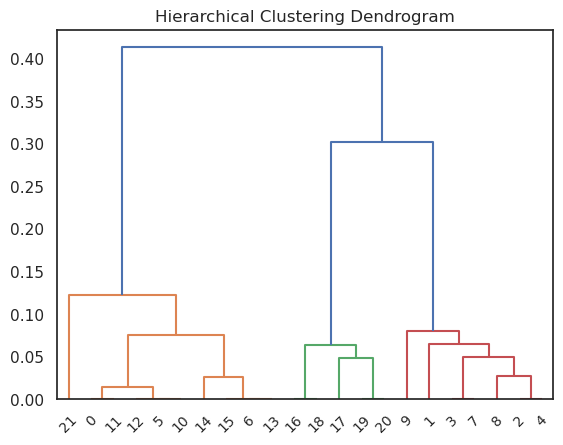

In [30]:
model = AgglomerativeClustering(distance_threshold=0.1, n_clusters=None, metric="precomputed", linkage="average")

model = model.fit(aut_fst.clip(0))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=10)

In [46]:
def divergence_divide(square_df):
    square_out = np.zeros((len(square_df), len(square_df)))
    for i in range(len(square_df)):
        for j in range(len(square_df)):
            square_out[i,j] = square_df.iloc[i,j]/((square_df.iloc[i,i]+square_df.iloc[j,j])/2)
    return square_out

In [53]:
aut_div = output_df.loc[(output_df.chr_type == "Aut") &
                       (output_df.stat == "Divergence")].iloc[:,:len(output_df.columns)-5].fillna(0)
pd.DataFrame(divergence_divide(aut_div))

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.000000,1.860231,1.920429,2.020961,1.700382,1.002400,1.168035,1.879393,1.872646,1.926306,...,1.064352,0.992399,1.092269,1.084404,1.782816,1.812602,1.846335,1.823487,1.579399,1.170440
1,1.860231,1.000000,1.121540,1.093337,1.009433,1.696643,1.706210,1.049700,1.077669,1.117876,...,1.820811,1.403304,1.843089,1.601978,1.397122,1.569294,1.445517,1.489697,1.370682,1.908805
2,1.920429,1.121540,1.000000,1.117794,0.999161,1.744368,1.804993,1.028976,0.709255,1.116069,...,1.889417,1.491076,1.935835,1.680561,1.418514,1.547947,1.391763,1.494052,1.346883,1.994530
3,2.020961,1.093337,1.117794,1.000000,1.008512,1.785453,1.892278,0.875494,1.133461,1.091627,...,1.938314,1.535191,1.997455,1.748631,1.417327,1.570369,1.407838,1.531111,1.380977,2.027902
4,1.700382,1.009433,0.999161,1.008512,1.000000,1.596313,1.589293,0.963234,1.057947,0.944964,...,1.716180,1.376046,1.740480,1.513137,1.342340,1.489614,1.374948,1.425296,1.298911,1.776922
5,1.002400,1.696643,1.744368,1.785453,1.596313,1.000000,1.133330,1.708858,1.725305,1.736913,...,0.990731,0.986179,1.086433,1.018267,1.690582,1.668308,1.720106,1.687118,1.509214,1.131895
6,1.168035,1.706210,1.804993,1.892278,1.589293,1.133330,1.000000,1.769159,1.790466,1.793204,...,1.202853,0.957360,1.085253,0.988483,1.684057,1.680634,1.730090,1.691018,1.565074,1.215757
7,1.879393,1.049700,1.028976,0.875494,0.963234,1.708858,1.769159,1.000000,1.039906,1.067304,...,1.833967,1.458903,1.878844,1.640478,1.366916,1.521707,1.384386,1.475492,1.336498,1.894917
8,1.872646,1.077669,0.709255,1.133461,1.057947,1.725305,1.790466,1.039906,1.000000,1.138204,...,1.837072,1.458523,1.868543,1.653622,1.444810,1.557807,1.400725,1.503322,1.353377,1.912926
9,1.926306,1.117876,1.116069,1.091627,0.944964,1.736913,1.793204,1.067304,1.138204,1.000000,...,1.881585,1.506429,1.905416,1.673773,1.410174,1.556167,1.402882,1.516074,1.364621,1.938254


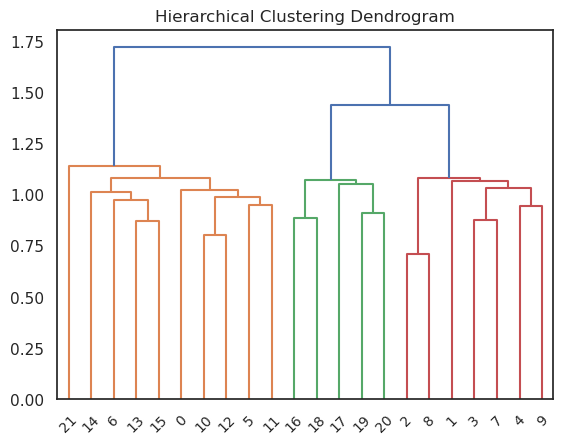

In [60]:
model = AgglomerativeClustering(distance_threshold=1.2, n_clusters=None, metric="precomputed", linkage="average")

model = model.fit(divergence_divide(aut_div))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=10)

In [61]:
model.labels_

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0])

Flexible intervals:

In [ ]:
def interval_creator(bed_l, window_size):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    df_l = []
    for c in bed_l.chrom.unique():
        print(c)
        start_l, end_l = [], []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_size = 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Current window encapsulates the final stretch of the interval.
            if current_size + k >= window_size:
                start_l.append(w_start), end_l.append(i+(window_size-current_size))
                w_start = i+(window_size-current_size)
                # If the window still contains full intervals, contigous windows until it cant.
                for x in range((k-window_size+current_size)//window_size):
                    start_l.append(w_start), end_l.append(w_start+window_size)
                    w_start += window_size
                current_size = j-w_start
            # Current window does not encapsulate per definition, so it has to be added to current size but nothing else.
            else:
                current_size += k
        df_l.append(pd.DataFrame({"chrom": c, "interval_start": start_l, "interval_end": end_l}))
    return pd.concat(df_l)